In [1]:
"""
This notebook collates the LF summaries with the geographic setting (weather + topography) and burn severity summaries
Author: maxwell.cook@colorado.edu
"""

import os, sys

# import custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# projection information
albers = 'EPSG:5070' # albers CONUS
utm = 'EPSG:32613' # UTM Zone 13N

# directories
cwd = Path(os.getcwd())
projdir = cwd.parents[1] # project home directory
maindir = cwd.parents[3] # main directory structure

print("Ready to go !")

Ready to go !


In [2]:
# load the aggregated FRP grids (regular 375m2 grids summarizing FRP from VIIRS)
fp = os.path.join(projdir,'data/spatial/mod/VIIRS/viirs_snpp_jpss1_afd_latlon_fires_pixar_gridstats.gpkg')
grid = gpd.read_file(fp)
print(f"\nThere are [{len(grid)}] grids across [{len(grid['Fire_ID'].unique())}] fires.\n")

# create a unique ID
grid['grid_idx'] = grid['Fire_ID'].astype(str) + grid['grid_index'].astype(str)

# add the centroid lat/lon to the grid data
df = grid.to_crs(4326) # WGS coords for lat/lon
df['x'] = df.geometry.centroid.x  # Longitude (x-coordinate)
df['y'] = df.geometry.centroid.y  # Latitude (y-coordinate)
grid = grid.merge(df[['grid_idx','x','y']], on='grid_idx', how='left')
del df
print(f"\n{grid.columns}\n")

# Drop any dupicate grids ...
print(f"Dropping [{grid.duplicated(subset=['grid_idx']).sum()}] duplicate grids.\n")
grid = grid.drop_duplicates(subset=['grid_idx'], keep='first')

ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db



There are [57232] grids across [100] fires.


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_idx', 'x', 'y'],
      dtype='object')

Dropping [0] duplicate grids.



Fractional overlap:
count    57232.000000
mean         2.023404
std          2.001402
min          0.000003
25%          0.587511
50%          1.493563
75%          2.771206
max         24.470760
Name: overlap, dtype: float64



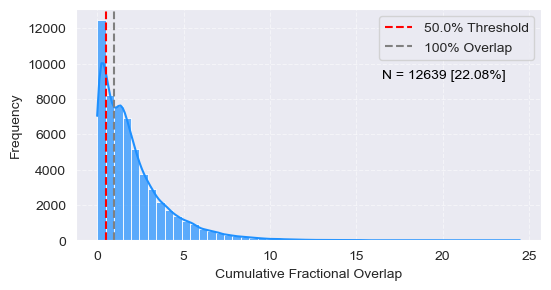

Plot saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/figures/grid_overlap_distribution.png

Dropping [12639 (22.08%)] grids with <50.0% fractional overlap.
44593


In [3]:
# Check out the distribution of grid overlap with FRP observations
thresh = 0.50
print(f"Fractional overlap:\n{grid['overlap'].describe()}\n")
n_small = grid[grid['overlap'] < thresh]['grid_idx'].count() # less than 5% spatial overlap

# Plot the distribution of the fractional overlap
plt.figure(figsize=(6,3))
sns.histplot(grid['overlap'], kde=True, bins=50, color='dodgerblue', alpha=0.7)

# Add vertical line for the threshold and for 100%
plt.axvline(x=thresh, color='red', linestyle='--', label=f'{thresh*100}% Threshold')
plt.axvline(x=1, color='grey', linestyle='--', label='100% Overlap')

# Customize the plot
# plt.title('Distribution of Grid Overlap Fraction')
plt.xlabel('Cumulative Fractional Overlap')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.text(16.5, plt.ylim()[1] * 0.7, 
         f'N = {n_small} [{round(n_small/len(grid)*100,2)}%]', 
         fontsize=10, color='black')

# Save the plot
out_path = os.path.join(projdir, 'figures/grid_overlap_distribution.png')
plt.savefig(out_path, dpi=300, bbox_inches='tight')

plt.show()
print(f"Plot saved to: {out_path}")

# filter out grids below the overlap threshold
print(f"\nDropping [{n_small} ({round(n_small/len(grid)*100,2)}%)] grids with <{thresh*100}% fractional overlap.")
grid = grid[grid['overlap'] >= thresh] # remove these observations
print(len(grid))

In [4]:
# Load the LANDFIRE and TreeMap summaries
fp = os.path.join(projdir,'data/tabular/mod/gridstats_lf.csv')
lf_df = pd.read_csv(fp)
lf_df.drop(columns=['Unnamed: 0'], inplace=True)
# Check on it
print(f"LF Attributes:\n{lf_df.columns}\n")
print(f"\tunique grids: {len(lf_df['grid_idx'].unique())}")
print(f"\t\t total rows: {len(lf_df)}")

LF Attributes:
Index(['grid_idx', 'fortypnm_gp', 'proportion', 'CC', 'CH', 'CBH', 'CBD',
       'BALIVE', 'SDI', 'QMD'],
      dtype='object')

	unique grids: 44193
		 total rows: 138853


In [5]:
# calculate the proportion of the gridcell that is forested
prop_forest = lf_df.groupby(['grid_idx'])['proportion'].sum().reset_index(name='prop_forest')
print(prop_forest.head())
# calculate the gridcell dominant forest types
dom_evt = lf_df.loc[lf_df.groupby('grid_idx')['proportion'].idxmax()]
dom_evt.rename(columns={'fortypnm_gp':'dom_fortyp'}, inplace=True)
# merge in the forest proportion
dom_evt = pd.merge(dom_evt, prop_forest, on='grid_idx', how='left')
print(dom_evt.head())

   grid_idx  prop_forest
0    819725    39.411765
1    821970    84.615385
2    821974    84.023669
3    821975    36.094675
4    821992    95.857988
   grid_idx   dom_fortyp  proportion         CC         CH         CBH  \
0    819725        Aspen   24.117647  35.000000  144.00000   93.925000   
1    821970        Aspen   39.644970  47.950820  151.31148  100.000000   
2    821974  Aspen–Mixed   29.585799  50.128204  176.66667    3.000000   
3    821975        Aspen   14.201183  30.714285  130.95238   89.714290   
4    821992   Spruce-fir   38.461538  54.661020  146.61017    5.169491   

         CBD      BALIVE        SDI       QMD  prop_forest  
0   1.000000   47.054203  16.542500  6.035000    39.411765  
1   1.000000   78.202250  23.178688  6.440983    84.615385  
2  10.820513  131.510330  32.630768  9.415385    84.023669  
3   1.000000   43.088160  13.214286  5.552381    36.094675  
4  13.203390  168.625370        NaN       NaN    95.857988  


In [6]:
dom_evt['dom_fortyp'].value_counts()

dom_fortyp
Ponderosa pine    14178
Lodgepole pine    10413
Spruce-fir         7748
Aspen              4294
Douglas-fir        3093
White fir          2720
Pinon-juniper      1548
Aspen–Mixed         199
Name: count, dtype: int64

In [7]:
# merge back the gridcell summaries
dom_evt = dom_evt[['grid_idx','dom_fortyp','prop_forest']]
lf_df = pd.merge(lf_df, dom_evt, on='grid_idx', how='left')
lf_df.head()

,grid_idx,fortypnm_gp,proportion,CC,CH,CBH,CBD,BALIVE,SDI,QMD,dom_fortyp,prop_forest
0,819725,Aspen,24.117647,35.00000,144.00000,93.925,1.00,47.054203,16.542500,6.035000,Aspen,39.411765
1,819725,Douglas-fir,1.176471,35.00000,110.00000,3.000,8.00,61.333350,inf,inf,Aspen,39.411765
2,819725,Spruce-fir,2.352941,52.50000,150.00000,5.500,11.75,141.676600,41.950000,5.275000,Aspen,39.411765
3,819725,Aspen–Mixed,11.764706,45.50000,176.00000,3.000,9.20,98.226616,34.850000,6.800000,Aspen,39.411765
4,821970,Aspen,39.644970,47.95082,151.31148,100.000,1.00,78.202250,23.178688,6.440983,Aspen,84.615385


## Load the topography and climate summaries

In [10]:
########################
# fire weather (gridmet)
fp = os.path.join(projdir,'data/earth-engine/exports/gridstats_gridmet_full.csv')
climate = pd.read_csv(fp)
print(f"Climate variables:\n{climate.columns}\n")

# tidy and merge the climate/topo
climate.rename(columns={
    'first_obs': 'first_obs_date',
    'last_obs': 'last_obs_date',
}, inplace=True) # for joining to the grid data

climate = climate[[
    'Fire_ID', 'first_obs_date', 'erc', 'erc_dv',
    'fm1000', 'fm1000_dv', 'rmin', 'rmin_dv', 'tmmx', 'tmmx_dv',
    'vpd', 'vpd_dv', 'vs', 'vs_dv'
]] # keep needed columns

climate['Fire_ID'] = climate['Fire_ID'].astype(str) # to match the grid column
grid['first_obs_date'] = grid['first_obs_date'].astype(str) # to match gee output
grid['last_obs_date'] = grid['last_obs_date'].astype(str) # to match gee output

# merge climate to the grid by fire id and first acquisition day
grid_clim = grid.merge(climate, on=['Fire_ID','first_obs_date'], how='left')
print(f"\n{grid_clim.columns}\n")

Climate variables:
Index(['system:index', 'Fire_ID', 'erc', 'erc_dv', 'first_obs', 'fm1000',
       'fm1000_dv', 'rmin', 'rmin_dv', 'tmmx', 'tmmx_dv', 'vpd', 'vpd_dv',
       'vs', 'vs_dv', '.geo'],
      dtype='object')


Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_idx', 'x', 'y', 'erc', 'erc_dv', 'fm1000', 'fm1000_dv', 'rmin',
       'rmin_dv', 'tmmx', 'tmmx_dv

In [12]:
############
# topography
fp = os.path.join(projdir,'data/earth-engine/exports/gridstats_topo.csv')
topo = pd.read_csv(fp)
# create a unique ID
topo['grid_idx'] = topo['Fire_ID'].astype(str) + topo['grid_index'].astype(str)
print(f"\n{topo.columns}\n")

# merge the topography to the grid
topo = topo[['grid_idx', 'elev', 'slope', 'aspect', 'chili', 'tpi']]
grid_clim_topo = grid_clim.merge(topo, on='grid_idx', how='left')
grid_clim_topo.columns


Index(['system:index', 'Fire_ID', 'aspect', 'chili', 'elev', 'grid_index',
       'slope', 'tpi', '.geo', 'grid_idx'],
      dtype='object')



Index(['grid_index', 'grid_area', 'afd_count', 'unique_days', 'overlap',
       'frp_csum', 'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95',
       'frp_p97', 'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp',
       'first_obs_date', 'last_obs_date', 't4_max', 't4_mean', 't5_max',
       't5_mean', 'day_count', 'night_count', 'frp_max_day', 'frp_max_night',
       'frp_csum_day', 'frp_csum_night', 'frp_mean_day', 'frp_mean_night',
       'frp_p90_day', 'frp_p90_night', 'frp_p95_day', 'frp_p95_night',
       'frp_p97_day', 'frp_p97_night', 'frp_p99_day', 'frp_p99_night',
       'frp_first_day', 'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry',
       'grid_idx', 'x', 'y', 'erc', 'erc_dv', 'fm1000', 'fm1000_dv', 'rmin',
       'rmin_dv', 'tmmx', 'tmmx_dv', 'vpd', 'vpd_dv', 'vs', 'vs_dv', 'elev',
       'slope', 'aspect', 'chili', 'tpi'],
      dtype='object')

In [13]:
# merge the FRP, climate, and topogrpahy to the forest metrics table
grid_clim_topo['grid_idx'] = grid_clim_topo['grid_idx'].astype(int)
grid_tm = lf_df.merge(grid_clim_topo, on=['grid_idx'], how='inner')
print(grid_tm.head(3))

   grid_idx  fortypnm_gp  proportion    CC     CH     CBH    CBD      BALIVE  \
0    819725        Aspen   24.117647  35.0  144.0  93.925   1.00   47.054203   
1    819725  Douglas-fir    1.176471  35.0  110.0   3.000   8.00   61.333350   
2    819725   Spruce-fir    2.352941  52.5  150.0   5.500  11.75  141.676600   

       SDI    QMD  ...   tmmx_dv       vpd    vpd_dv        vs     vs_dv  \
0  16.5425  6.035  ...  3.825737  1.632481  0.434491  3.350589 -0.701609   
1      inf    inf  ...  3.825737  1.632481  0.434491  3.350589 -0.701609   
2  41.9500  5.275  ...  3.825737  1.632481  0.434491  3.350589 -0.701609   

          elev      slope      aspect       chili        tpi  
0  2907.785585  27.233212  143.266123  189.301124  27.759364  
1  2907.785585  27.233212  143.266123  189.301124  27.759364  
2  2907.785585  27.233212  143.266123  189.301124  27.759364  

[3 rows x 74 columns]


In [14]:
len(grid_tm)

138853

In [15]:
grid_tm.columns

Index(['grid_idx', 'fortypnm_gp', 'proportion', 'CC', 'CH', 'CBH', 'CBD',
       'BALIVE', 'SDI', 'QMD', 'dom_fortyp', 'prop_forest', 'grid_index',
       'grid_area', 'afd_count', 'unique_days', 'overlap', 'frp_csum',
       'frp_max', 'frp_min', 'frp_mean', 'frp_p90', 'frp_p95', 'frp_p97',
       'frp_p99', 'frp_first', 'day_max_frp', 'dt_max_frp', 'first_obs_date',
       'last_obs_date', 't4_max', 't4_mean', 't5_max', 't5_mean', 'day_count',
       'night_count', 'frp_max_day', 'frp_max_night', 'frp_csum_day',
       'frp_csum_night', 'frp_mean_day', 'frp_mean_night', 'frp_p90_day',
       'frp_p90_night', 'frp_p95_day', 'frp_p95_night', 'frp_p97_day',
       'frp_p97_night', 'frp_p99_day', 'frp_p99_night', 'frp_first_day',
       'frp_first_night', 'Fire_ID', 'Fire_Name', 'geometry', 'x', 'y', 'erc',
       'erc_dv', 'fm1000', 'fm1000_dv', 'rmin', 'rmin_dv', 'tmmx', 'tmmx_dv',
       'vpd', 'vpd_dv', 'vs', 'vs_dv', 'elev', 'slope', 'aspect', 'chili',
       'tpi'],
      dtype='ob

In [16]:
# create a subset of columns
grid_tm = grid_tm[[
    'Fire_ID', 'Fire_Name', 'grid_idx', 'fortypnm_gp', 'proportion',
    'CC', 'CH', 'CBH', 'CBD', 'BALIVE', 'SDI', 'QMD',
    'dom_fortyp', 'prop_forest', 'grid_index', 'grid_area',
    'afd_count', 'day_count', 'night_count', 'unique_days', 'overlap', 'frp_csum',
    'frp_max', 'frp_min', 'day_max_frp', 'dt_max_frp', 'first_obs_date', 'last_obs_date',
    'erc', 'erc_dv', 'fm1000', 'fm1000_dv', 'rmin', 'rmin_dv', 'tmmx', 'tmmx_dv',
    'vpd', 'vpd_dv', 'vs', 'vs_dv', 'elev', 'slope', 'aspect', 'chili', 'tpi',
    'x', 'y', 'geometry'
]]

# save this file out.
out_fp = os.path.join(projdir,'data/tabular/mod/gridstats_lf_gs.csv')
grid_tm.to_csv(out_fp)
print(f"Saved file to: {out_fp}")

Saved file to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/gridstats_lf_gs.csv
